# Dataset background information

The dataset contain the monthly average prices of gold for years 2000-2011.

## Data-dictionary

It contains 2 columns, "Date" & "Price" only. 


# Objective of analysis

We will first decompose the time-series models. Then we will transform the dataset by several methods, such as taking natural-log & differencing, ultimately achieving stationarity. 

You have to go to https://www.quandl.com/ and sign up so as to get your own API key to get the data. Fill in your API key of quandl.com and assign to the vairable "QUANDL_KEY" above.

In [9]:
# Import Libraries needed to load the data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns 
import sklearn
from sklearn.linear_model import LogisticRegression
%matplotlib inline

import quandl
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.simplefilter("ignore")

In [10]:
# import files & check out the details

QUANDL_KEY = 'oPvyzmpK2xVnmepgCvgm' # replace {key} with your own API key
quandl.ApiConfig.api_key = QUANDL_KEY

# Download the prices of gold for years 2000-2011
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD', 
                start_date='2000-01-01', 
                end_date='2011-12-31')

# Change the column name from "Value" to "price"
df.rename(columns={'Value': 'price'}, inplace=True)
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (184, 1)


,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-28,279.69
2000-04-30,279.69


There are some duplicate values in the series. 
As shown above, there is an entry for 2000-04-28 and 2000-04-30, both with the same value 279.69. 

To deal with this issue, we resample to monthly data by only taking the last available value (this does not change any of the actual values; it only removes potential duplicates in each month).

In [11]:
# Resample by month and only take the last available value
df = df.resample('M').last()
print(f'Shape of DataFrame: {df.shape}')
df.head()

Shape of DataFrame: (144, 1)


,price
Date,
2000-01-31,284.31
2000-02-29,299.86
2000-03-31,286.39
2000-04-30,279.69
2000-05-31,275.19


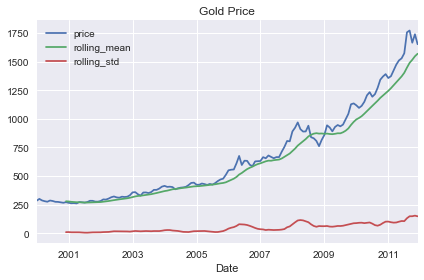

In [12]:
# Add rolling mean and standard deviation with a window size of 12 months 
WINDOW_SIZE = 12
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()
df.plot(title='Gold Price')

# Automatically adjust the padding between and around the subplot
import matplotlib.pyplot as plt
plt.tight_layout()
plt.show()

From the preceding plot, we can see that there is a non-linear growth pattern in the 12-month moving average and that the rolling standard deviation increases over time. That is why we decided to use the multiplicative model.

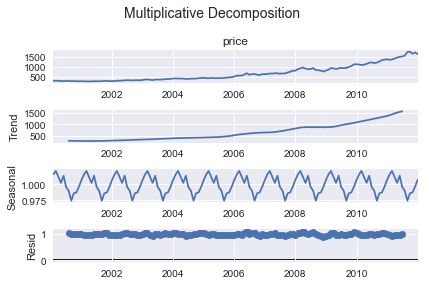

In [13]:
# Carry out seasonal decomposition using the multiplicative model
decomposition_results = seasonal_decompose(df.price, model='multiplicative')
decomposition_results.plot().suptitle('Multiplicative Decomposition', fontsize=14)

plt.tight_layout()
plt.show()

In the decomposition plot, we can see the extracted component series: trend, seasonal, and random (residual). To evaluate whether the decomposition makes sense, we can look at the random component. If there is no discernible pattern (in other words, the random component is indeed random), then the fit makes sense.

## Testing for stationarity in time series

A stationary time series is a series in which statistical properties such as mean, vairance, and covariance are constant over time. Stationarity is a desired characteristic of time series as it makes modeling and extraplating (forecasting) into the future more feasible. 


some drawbacks of non-stationary data are:
    - Variance can be msispecified by the model
    - Worse model fit
    - Cannot leverage valuable time-dependent patterns in the data
    
    
In this recipe, we show you how to test the time series for stationarity. To do so, we employ the folling methods:
    
    - The Augmented Dickey-Fuller (ADF) test
    - The Kwiatkowski-Philips-Schmidt-Shin (KPSS) test
    - Plots of the (partial) autocorrelation function (PACF/ACF)
    
We investigate the stationarity of monthly gold prices from the years 2000-2011

In [14]:
#define function for running the ADF test
def adf_test(x):
    indices = ['Test Statistic', 'p-value',
               '# of Lags Used', '# of Observations Used']
    adf_test = adfuller(x, autolag='AIC')
    results = pd.Series(adf_test[0:4], index=indices)
    for key, value in adf_test[4].items():
        results[f'Critical Value ({key})'] = value
    
    return results

# applyl ADf test to the price data
adf_test(df.price)

Test Statistic              3.510499
p-value                     1.000000
# of Lags Used             14.000000
# of Observations Used    129.000000
Critical Value (1%)        -3.482088
Critical Value (5%)        -2.884219
Critical Value (10%)       -2.578864
dtype: float64

The null hypothesis of the ADF test states that the time series is not stationary. With a p-value of 1 (or equivalently, the test statistics larger than the critical value for the selected confidence level), we have no reason to rejcet the null hypothesis, meaning that we can conclude that the series is not stationary.


Remarks:
* As p-value is not less than 0.05 (i.e. 1.0 in this case), null hypothesis is NOT rejected. 

In [15]:
#define function for running the KPSS test
def kpss_test(x, h0_type='c'):
    indices = ['Test Statistic', 'p-value', '# of Lags']
    kpss_test = kpss(x, regression=h0_type)
    results = pd.Series(kpss_test[0:3], index=indices)
    for key, value in kpss_test[3].items():
        results[f'Critical Value ({key})'] = value
        
    return results

kpss_test(df.price)

Test Statistic            0.985671
p-value                   0.010000
# of Lags                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

The null hypothesis of the KPSS test is that the time series is stationary. With a p-value of 0.01 (or test statistic greater than the selected critical value), we have reasons to reject the null hypothesis in favor of the alternative one, meaning that the series is not stationary.


Remarks:
* As p-value is less than 0.05 (i.e. 0.01 in this case), null hypothesis is rejected. 

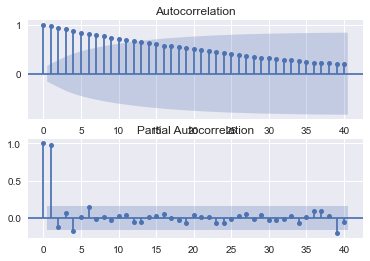

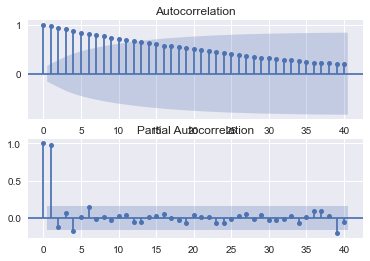

In [16]:
#Generate the ACF/PACF plots
import matplotlib.pyplot as plt

N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05
fig, ax = plt.subplots(2,1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS,
         alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS,
          alpha=SIGNIFICANCE_LEVEL)

In the ACF plot, we can see that there are significant autocorrelations (above the 95% confidence interval, corresponding to the selected 5% significance level). There are also some significant autocorrelations at lags 1 and 4 in the PACF plot.

Summary:
1. We defined a function used for running the ADF test and printing out the results. We specified ```autolag='AIC'``` in the ```adfuller``` function , so the number of considered lags is automatically selected based on the Akaike Information Criterion (AIC). Alternatively, we could select this value manually.
2. For the ```kpss``` function, we specified the ```regression``` argument. A value of ```'c'``` corresponds to the null hypothesis stating that the series is level-stationary, while ```'ct'``` corresponds to trend-stationary (removing the trend from the series would make it level-staionary).
3. For all the tests and the autocorrelation plots, we selected the significance level of 5%, which is the probability of rejecting the null hypothesis (H0) when it is, in fact, true.

## Correcting for stationarity in time series

In this recipe, we investigate how to make a non-stationary time series stationary by using the following transformations:
    
 - Deflation: Accounting for inflation in monetary series using the Consumer Price index (CPI)
 - Natural logarithm: Making the exponential trend closer to linear
 - Differencing: Taking the difference between the current observation and a lagged value (observation x time points before it)
    
We use the same data that we used in the ```Testing for stationarity in time series ``` recipe. The conclusion from that recipe was that the time series of monthly gold prices from 2000-2011 was not stationary.

In [17]:
#Correcting for stationarity in time series

#Import libraries and update inflation data
import cpi
import pandas as pd
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from utils import test_autocorrelation 

# update the CPI data (if needed)
#cpi.update()

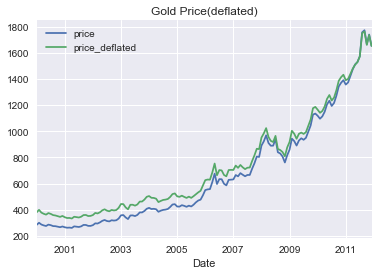

In [18]:
#Deflate the gold prices (to 2011-12-31 USD values) and plot the results

#set the deflation target date
DEFL_DATE = date(2011, 12, 31)

#change the index (i.e. Date) to datetime structure and extract date
df['dt_index'] = df.index.map(lambda x: x.to_pydatetime().date())

#generate new column "price_deflated" by applying cpi function 
#which inflat the old price to 31-12-2011 (deflation date) value
df['price_deflated'] = df.apply(lambda x:
                                cpi.inflate(x.price,
                                            x.dt_index,
                                            DEFL_DATE),
                                axis=1)

#plot the price and price_deflated
df[['price', 'price_deflated']].plot(title='Gold Price(deflated)');

As there is a inflation rate over time, the value of the deflated price in the past is actually higher than the original price

<AxesSubplot:title={'center':'Gold Price (logged)'}, xlabel='Date'>

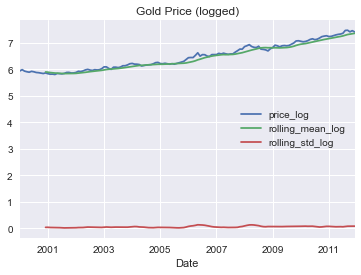

In [19]:
#3 Deflate the series using a natural logarithm and plot it with the rolling metrics
import numpy as np

WINDOW = 12
selected_columns = ['price_log', 'rolling_mean_log',
                    'rolling_std_log']

#genereate new column "price_log" by taking
#natural logarithm on column "price_deflated"
df['price_log'] = np.log(df.price_deflated)

#genereate new column "rolling_mean_log" by taking
#rolling mean with 12 months window on column "price_log"
df['rolling_mean_log'] = df.price_log.rolling(window=WINDOW) \
.mean()

#genereate new column "rolling_std_log" by taking
#rolling standard deviation with 12 months window on column "price_log"
df['rolling_std_log'] = df.price_log.rolling(window=WINDOW) \
.std()

#plot the logged price, its mean and sd
df[selected_columns].plot(title='Gold Price (logged)')

From the preceding plot, we can see that the log transformation did its job, that is, it made the exponential trend linear. 

Remarks:
We can see that the standard deviation curve improves after transformation and is almost constant, which is one of the criteria of being stationarity.

ADF test statistic: 0.89 (p-val: 0.99)
KPSS test statistic: 1.04 (p-val: 0.01)


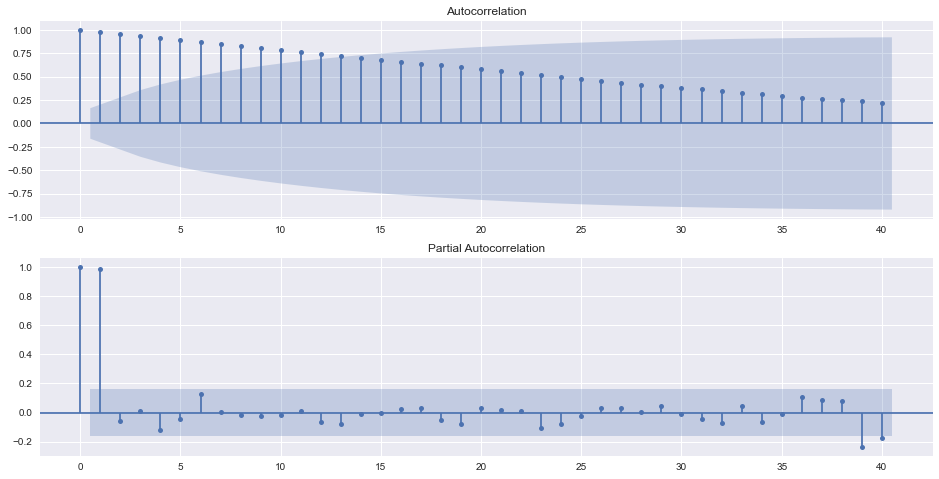

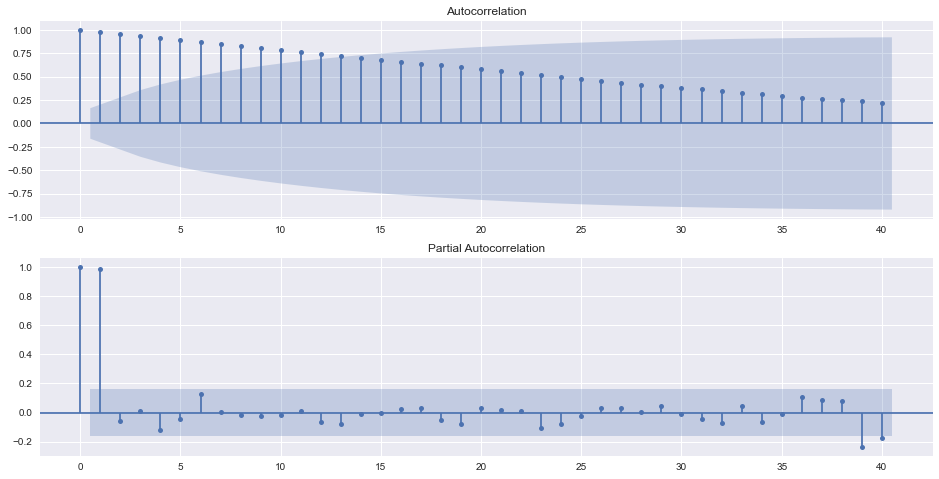

In [20]:
#4 use test_autocorrelation (helper function)
test_autocorrelation(df.price_log)


After inspecing the results of the statistical tests and the ACF/PACF plots, we can conclude that deflation and a natural algorithm were not enough to make the gold prices stationary.

Recall:

The null hypothesis of the ADF test is that the time series is NOT stationary. 
The null hypothesis of the KPSS test is that the time series is stationary. 

However, it still improves a little bit by checking the test statistics and p-value of both tests:
ADF test: 

   - test stat:3.51 --> 0.89
   - p-value: 1.00 --> 0.99
    
KPSS test: 

   - test stat:0.99 --> 1.04
   - p-value: 0.01 --> 0.01 

<AxesSubplot:title={'center':'Gold Price (1st differences)'}, xlabel='Date'>

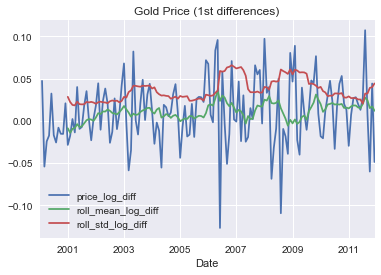

In [21]:
#5 apply differencing

selected_columns = ['price_log_diff','roll_mean_log_diff',
 'roll_std_log_diff']

#genereate new column "price_log_diff" by taking
#natural logarithm on column "price_deflated" (1st difference)
df['price_log_diff'] = df.price_log.diff(1)

#genereate new column "roll_mean_log_diff" by taking
#rolling mean with 12 months window on column "price_log_diff"
df['roll_mean_log_diff'] = df.price_log_diff.rolling(WINDOW) \
 .mean()

#genereate new column "roll_std_log_diff" by taking
#rolling standard deviation with 12 months window on column "price_log_diff"
df['roll_std_log_diff'] = df.price_log_diff.rolling(WINDOW) \
 .std()

#plot the logged price, its mean and sd
df[selected_columns].plot(title='Gold Price (1st differences)')

The transformed gold prices make the impression of being stationary - the series oscillates around 0 with more or less constant variance. At least there is no visible trend.

ADF test statistic: -9.13 (p-val: 0.00)
KPSS test statistic: 0.37 (p-val: 0.09)


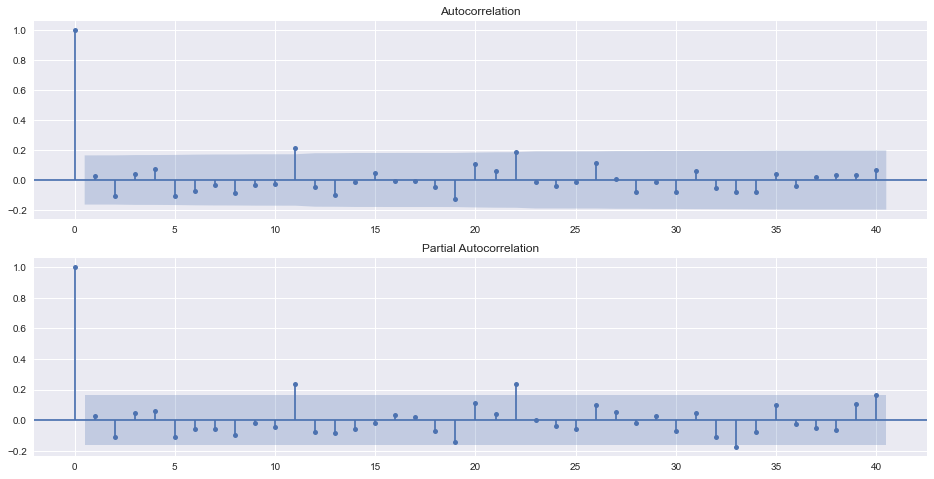

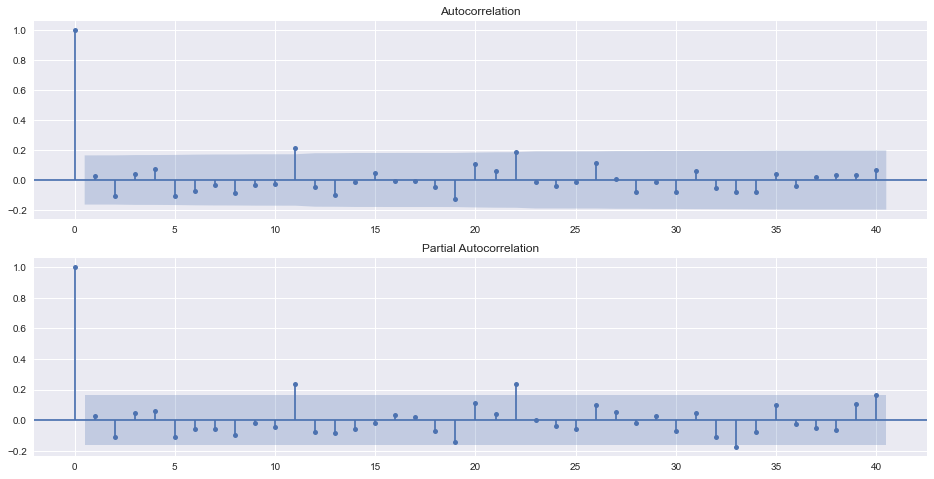

In [22]:
#6 test if stationary again

test_autocorrelation(df.price_log_diff.dropna())

#duplicate plots to be fixed (milton chan)

## Final model:

After applying the first differences, the series became stationary at the 5% significance level (according to both tests). In the ACF/PACF plots, we can see that there was a significant value of the function at lag 11 and 22. This might indicate some kind of seasonality or simply be a false signal. Using a 5% significance level means that 5% of the values might lie outside the 95% confidence interval - even when the underlying process does not show any autocoreelation or partial autocorrelation.


Recall:

The null hypothesis of the ADF test is that the time series is NOT stationary. 

The null hypothesis of the KPSS test is that the time series is stationary. 

## Adjusting for seasonality (Further testing)

The considered gold prices do not contain obvious seasonality. However, if the dataset shows seasonal patterns, there are a few potential solutions:
    
- Adjustment by differencing: Instead of using the first order
    differencing, use a higher-order one, for example, if there is yearly
    seasonality in monthly data, use diff (12)

In [23]:
#we can employ the following tests to investigate stationarity:ADF, KPSS and Philips-Perron (PP)

from pmdarima.arima import ndiffs, nsdiffs

print(f"Suggested # of differences (ADF): {ndiffs(df.price, test='adf')}")
print(f"Suggested # of differences (KPSS): {ndiffs(df.price,test='kpss')}")
print(f"Suggested # of differences (PP): {ndiffs(df.price, test='pp')}")

Suggested # of differences (ADF): 1
Suggested # of differences (KPSS): 2
Suggested # of differences (PP): 1


It suggests that we should take 1 or 2 order differences to achieve stationarity from 3 tests above.

The library also contains two tests for seasonal differences:

- Osborn, Chui, Smith, and Birchenhall (OCSB)
- Canova-Hansen (CH)

To run them, we also need to specify the frequency of our data (12, in our case) as we are working with monthly data:

In [24]:
#other two tests for seasonal differences

print(f"Suggested # of differences (OSCB): {nsdiffs(df.price, m=12,test='ocsb')}")
print(f"Suggested # of differences (CH): {nsdiffs(df.price, m=12,test='ch')}")

Suggested # of differences (OSCB): 0
Suggested # of differences (CH): 0


Both tests results showing 0. It indicates that there are no seasonality. 

## Insight

After dividing the CPI data, taking natural-log & the first-difference of the time-series data, we still have the constant mean higher than zero. That means gold price trend is having an increasing trend (reverse meaning of first difference >0) exponentially (reverse meaning of taking natural-log), in this inflation world (reverse meaning of dividing CPI data).

As we know, inflation is increasing throughout the years. We have to invest to keep our money valuable. With above analysis, gold can keep your money valuable in this inflation world and even still have a positive return with referencing to the inflation data.


# Extra-mile for the data

We can use auto_arima to revisit the (p,q,s) elements to achieve staionarity. Moreover, we can compare the performance of traditional statistical model (ARIMA) and deep learning model (RNN) for forecasting the trend of this commodity.